<a id='start'></a>

# Исследование факторов, влияющих на перегрев на этапе производства стали

Для оптимизации производственных расходов металлургическому комбинату необходимо уменьшить потребление электроэнергии на этапе обработки стали.

Описание этапа обработки стали

Сталь обрабатывают в металлическом ковше, который изнутри облицован огнеупорным кирпичом. Сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами, установленными в крышке ковша. 
Производится десульфация. Путем добавления примесей корректируется химический состав и отбираются пробы. Происходит легирование стали: подаются куски сплава из бункера для сыпучих материалов или проволока через специальный трайб-аппарат.
Перед введением добавок измеряется температура стали, производится её химический анализ. Затем температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

**Цель проекта:**

Построить модель, которая предскажет температуру стали, что поможет снизить затраты бизнеса на электроэнергию.

Необходимо достичь значения MAE ≤ 6.8

**Задачи:**
1. [Провести исследовательский анализ, обработать данные и подготовить признаки;](#step1) <br>
    1.1 [data_arc_new.csv — данные об электродах;](#step1_1)<br>
    1.2 [data_bulk_new.csv — данные о подаче сыпучих материалов;](#step1_2)<br>
    1.3 [data_gas_new.csv — данные о продувке сплава газом;](#step1_3)<br>
    1.4 [data_temp_new.csv — результаты измерения температуры;](#step1_4)<br>
    1.5 [data_wire_new.csv — данные о проволочных материалах;](#step1_5)<br>
2. [Объединить признаки в один датафрейм;](#step2)
3. [Обучить модели;](#step3)<br>
    3.1 [Линейная регрессия;](#step3_1)<br>
    3.2 [Случайный лес;](#step3_2)<br>
    3.3 [CatBoost;](#step3_3)<br>
4. [Протестировать лучшую модель;](#step4)
5. [Провести анализ важности факторов;](#step5)
6. [Подвести итог.](#step6)

## Предобработка данных, подготовка признаков

Импорт библиотек:

In [2]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import shap
import warnings

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pyod.models.knn import KNN

from catboost import CatBoostRegressor
from catboost.utils import eval_metric

warnings.filterwarnings('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### 1. Данные об электродах <a id='step1_1'></a>

Взглянем на данные:

In [3]:
data_arc = pd.read_csv('datasets/data_arc_new.csv')

In [4]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
data_arc.duplicated().sum()

0

In [7]:
data_arc['key'].nunique()

3214

В данных об электродах отсутствуют пропуски и дубликаты, в данных 14876 записи.<br>
Для некоторых партий записи отсутствуют (3214 vs 3239 для газа).<br>

Количество итераций для различных партий:

In [9]:
data_arc.pivot_table(index='key', values='Активная мощность', aggfunc='count').describe()

,Активная мощность
count,3214.000000
mean,4.628500
std,1.608647
min,1.000000
25%,4.000000
50%,4.000000
75%,6.000000
max,16.000000


Чаще всего проходит 4 итерации, их количество варьируется от 1 до 16.

Распределение значений активной мощности:

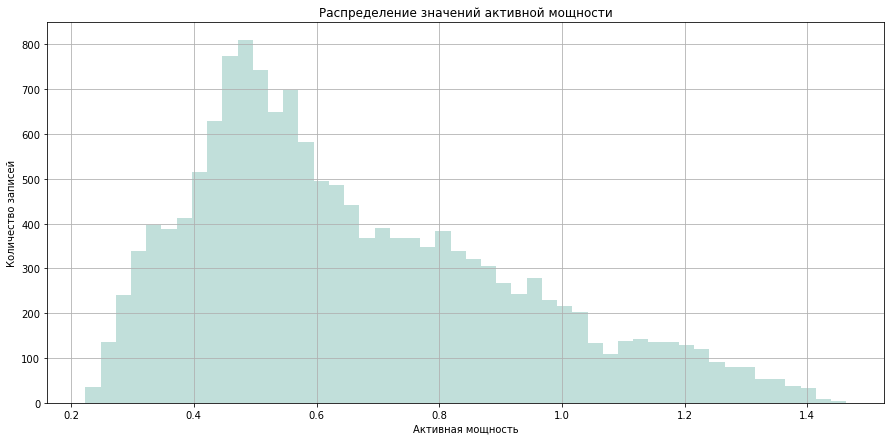

In [10]:
data_arc['Активная мощность'].hist(bins=50, figsize=(15, 7), color='#A7D2CB', alpha=0.7)
plt.xlabel('Активная мощность')
plt.ylabel('Количество записей')
plt.title('Распределение значений активной мощности')
plt.show()

На первый взгляд выбросов нет. Распределение асимметрично. Убедимся в этом:

In [11]:
data_arc['Активная мощность'].describe()

count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: Активная мощность, dtype: float64

<AxesSubplot:>

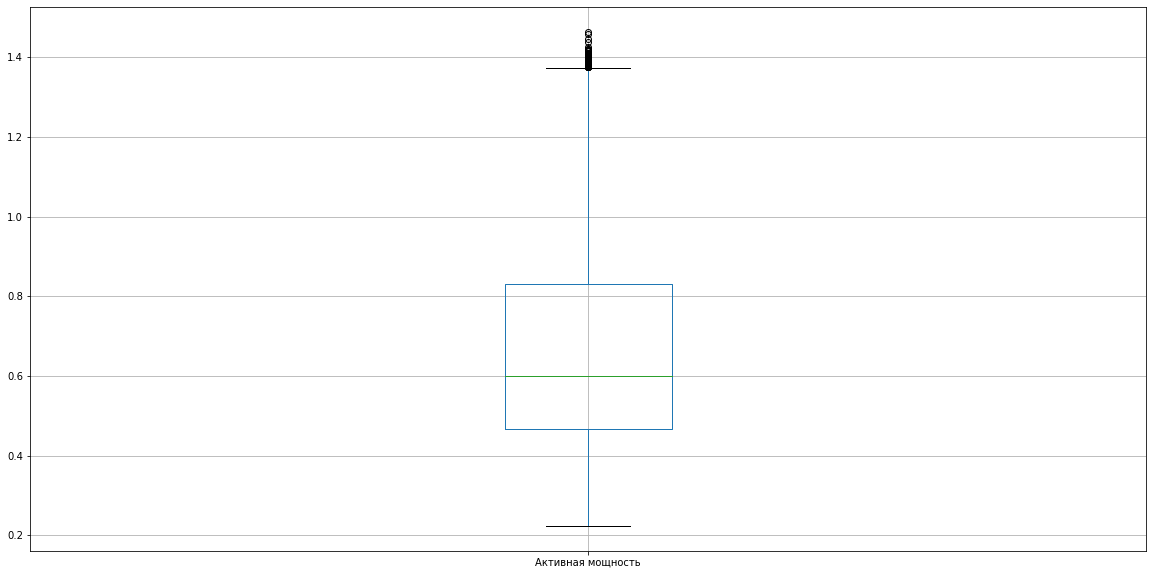

In [12]:
data_arc.boxplot(column='Активная мощность', figsize=(20, 10))

Медиана смещена влево, есть небольшие выбросы у верхней границы.

Распределение реактивной мощности:

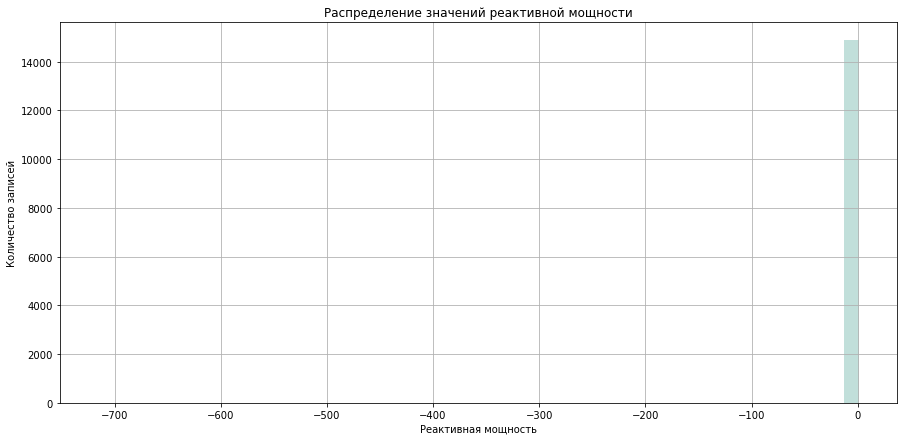

In [13]:
data_arc['Реактивная мощность'].hist(bins=50, figsize=(15, 7), color='#A7D2CB', alpha=0.7)
plt.xlabel('Реактивная мощность')
plt.ylabel('Количество записей')
plt.title('Распределение значений реактивной мощности')
plt.show()

Здесь явно есть выбросы, убедимся в этом:

In [14]:
data_arc['Реактивная мощность'].describe()

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: Реактивная мощность, dtype: float64

In [15]:
data_arc['Реактивная мощность'].sort_values().unique()

array([-7.15479924e+02,  1.53777000e-01,  1.53921000e-01, ...,
        1.22306300e+00,  1.25862800e+00,  1.27028400e+00])

Похоже, одно значение (-715.479924) является выбросом, выбивающимся из общей картины. Убедимся в этом:

(0.0, 1.4)

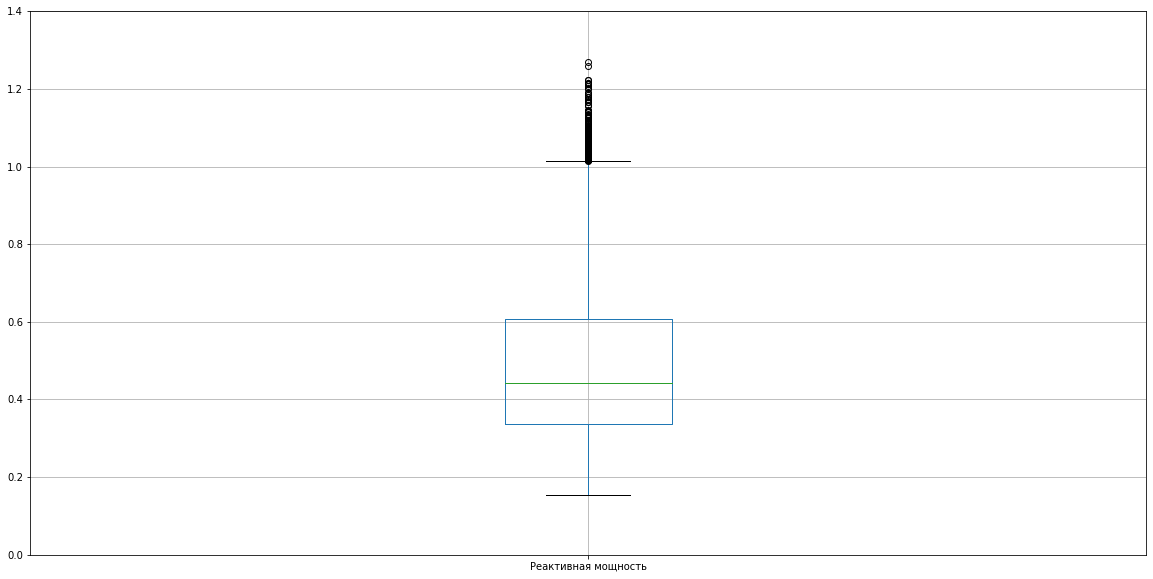

In [16]:
data_arc.boxplot(column='Реактивная мощность', figsize=(20, 10))
plt.ylim(0, 1.4) 

Помимо значения -715.479924, есть выбросы у верхней границы.

Активная мощность - это полезная часть мощности, та часть, которая определяет прямое преобразования электрической энергии в другие необходимые виды энергии.
Реактивная мощность - как правило, является «вредной» или «паразитной».
Есть ли между ними связь:

In [17]:
data_arc.corr()

,key,Активная мощность,Реактивная мощность
key,1.000000,-0.010220,-0.004834
Активная мощность,-0.010220,1.000000,0.031164
Реактивная мощность,-0.004834,0.031164,1.000000


Активная и реактивная мощности не взаимосвязаны, судя по предварительному анализу, что странно. Скорее всего это влияние выбросов.

#### Предобработка данных об электродах и создание признаков

Скопируем данные для работы

In [18]:
arc = data_arc.copy()

Ранее выяснено, что в реактивной мощности есть явный выброс (-715.479924), его необходимо удалить.

Исключим выброс в реактивной мощности (в исследовательском анализе выяснено, что это единственное отрицательное значение)

In [19]:
arc = arc[arc['Реактивная мощность'] > 0]

Убедимся что это значение было единственным

In [20]:
arc.shape

(14875, 5)

После того, как избавились от выброса, посмотрим как связаны активная и реактивная мощности

In [21]:
arc.corr()

,key,Активная мощность,Реактивная мощность
key,1.000000,-0.010226,-0.013169
Активная мощность,-0.010226,1.000000,0.966373
Реактивная мощность,-0.013169,0.966373,1.000000


Как предполагалось, активная и реактивные мощности взаимосвязаны. Нельзя оставлять их одновременно в качестве отдельных признаков.

Данные об электродах можно объединить в один фактор - суммарную работу по партии. Сама работа вычисляется следующим образом:
$$
A=Nt,
$$
где N - полная мощность, t - длительность нагрева.
Полную мощность можно вычислить следующим образом:
$$
N = \sqrt{P^2 + Q^2},
$$
где P - активная мощность, Q - реактивная мощность.

Вычислим недостающее значение - время нагрева. Вынесем это значение в отдельный столбец.

In [22]:
arc['heating_duration'] = (pd.to_datetime(arc['Конец нагрева дугой']) - pd.to_datetime(arc['Начало нагрева дугой'])).dt.total_seconds()

In [23]:
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heating_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0


По вышеуказанной формуле вычислим работу и вынесем значение в отдельный столбец

In [24]:
arc['work'] = arc['heating_duration'] * (((arc['Активная мощность']**2) + (arc['Реактивная мощность']**2)) ** 0.5)

In [25]:
arc.head(6)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,heating_duration,work
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,159.830252
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137.0,60.312695


Создадим новую таблицу с суммарной работой

In [26]:
arc_work = arc.pivot_table(index='key', values='work', aggfunc='sum')

In [27]:
arc_work.head()

,work
key,
1,770.282114
2,481.760005
3,722.837668
4,683.455597
5,512.169934


In [28]:
arc_work.shape

(3214, 1)

Добавим еще один признак для обучения - количество включений электродов

In [29]:
arc_work['arc_count'] = arc.pivot_table(index='key', values='work', aggfunc='count')['work']

In [30]:
arc_work.head()

,work,arc_count
key,,
1,770.282114,5
2,481.760005,4
3,722.837668,5
4,683.455597,4
5,512.169934,4


### 2. Данные о подаче сыпучих материалов <a id='step1_2'></a>

Взглянем на данные

In [31]:
data_bulk = pd.read_csv('datasets/data_bulk_new.csv')

In [32]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [33]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [34]:
data_bulk.duplicated().sum()

0

In [35]:
data_bulk['key'].nunique()

3129

В данных об объемах подачи сыпучих материалов отсутствуют дубликаты, но в каждом признаке есть пропуски, в большинстве случаев пропусков слишком много. <br>
Разные цифры в названии признака - разный сыпучий материал.<br>
Каждый объект - информация об отдельной партии.<br>
С чем можно работать:
1. key - есть для всех объектов
2. Bulk 3 - есть ~1/3 данных от всего количества
3. Bulk 4 - есть ~1/3 данных от всего количества
4. Bulk 6 - есть ~1/6 данных от всего количества
5. Bulk 12 - есть ~2/3 данных от всего количества
6. Bulk 14 - есть ~90% данных от всего количества
7. Bulk 15 - есть ~2/3 данных от всего количества


Для некоторых партий записи отсутствуют (3129 vs 3239 для газа).

Распределение данных:

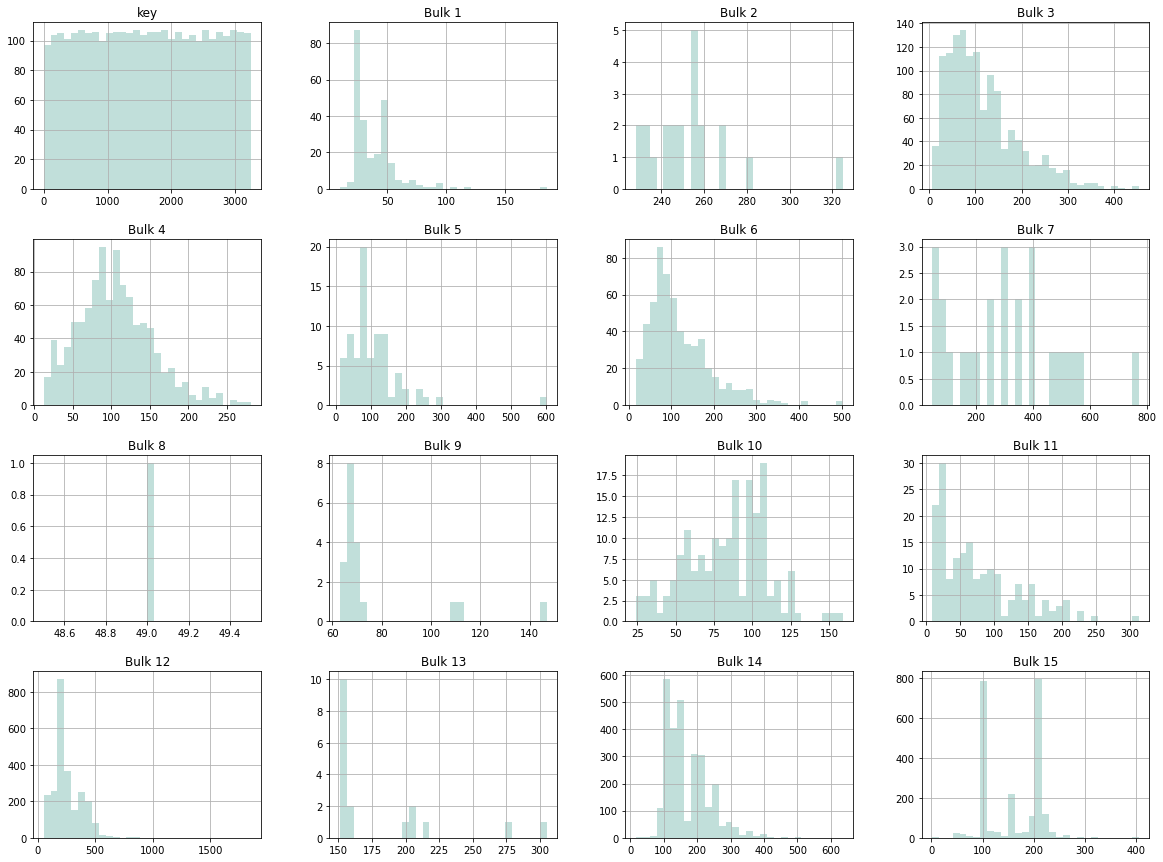

In [36]:
data_bulk.hist(bins=30, figsize=(20, 15), color='#A7D2CB', alpha=0.7)
plt.show()

1. Bulk 3 - медиана смещена влево, есть аномальные значения
2. Bulk 4 - распределение близко к нормальному
3. Bulk 6 - медиана смещена влево, есть аномальные значения
4. Bulk 12 - есть выбросы
5. Bulk 14 - есть выбросы
6. Bulk 15 - несколько пиковых значений

In [37]:
# Функция для построения графиков для сыпучих материалов:
def bulk_plotter(name):
    data_bulk[name].hist(bins=50, figsize=(15, 7), color='#A7D2CB', alpha=0.7)
    plt.xlabel('Объем')
    plt.ylabel('Количество записей')
    plt.title(f'Распределение объемов {name}')
    plt.show()
    
    data_bulk.boxplot(column=name, figsize=(20, 10))
    plt.show() 

**Bulk 3:**

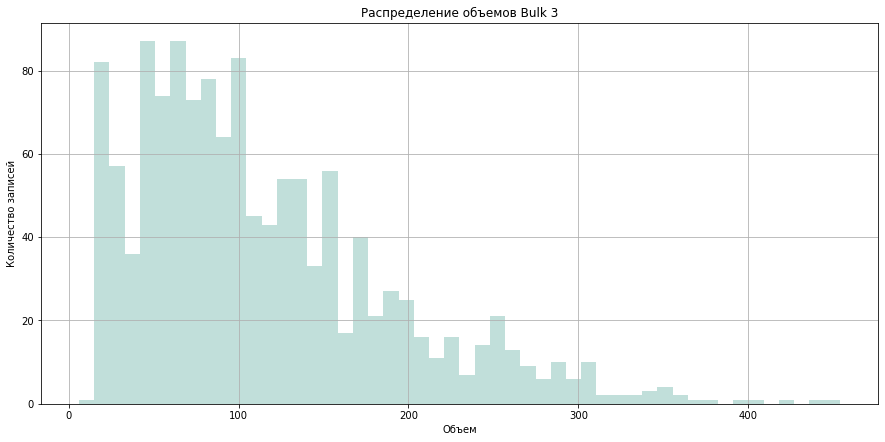

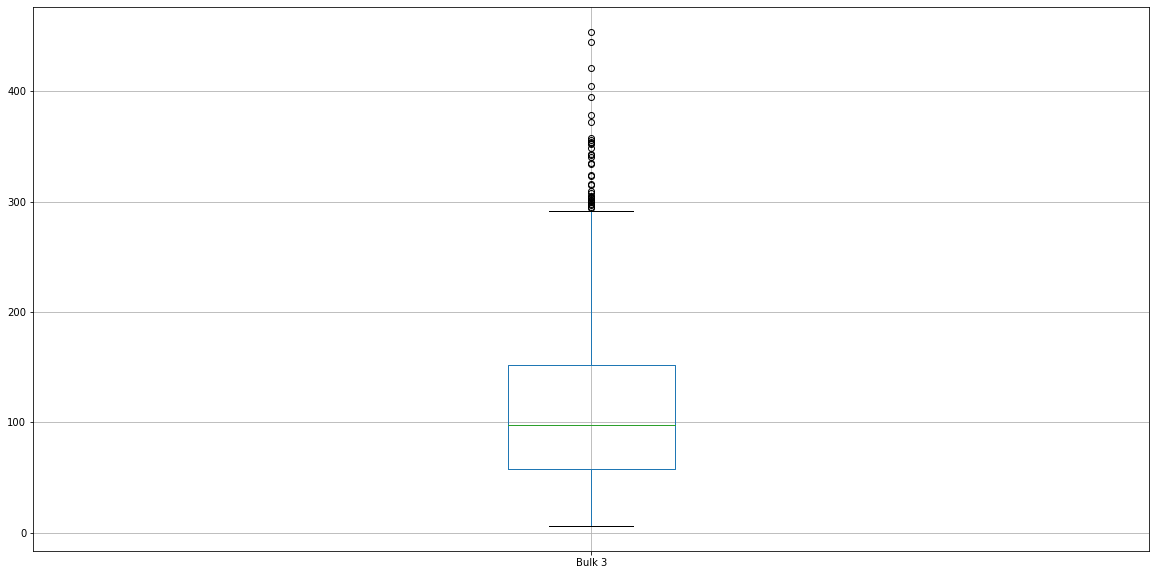

In [38]:
bulk_plotter('Bulk 3')

In [39]:
data_bulk['Bulk 3'].describe()

count    1298.000000
mean      113.879045
std        75.483494
min         6.000000
25%        58.000000
50%        97.500000
75%       152.000000
max       454.000000
Name: Bulk 3, dtype: float64

Предположения подтвердились: в Bulk 3 медиана смещена влево, есть аномальные значения

**Bulk 6:**

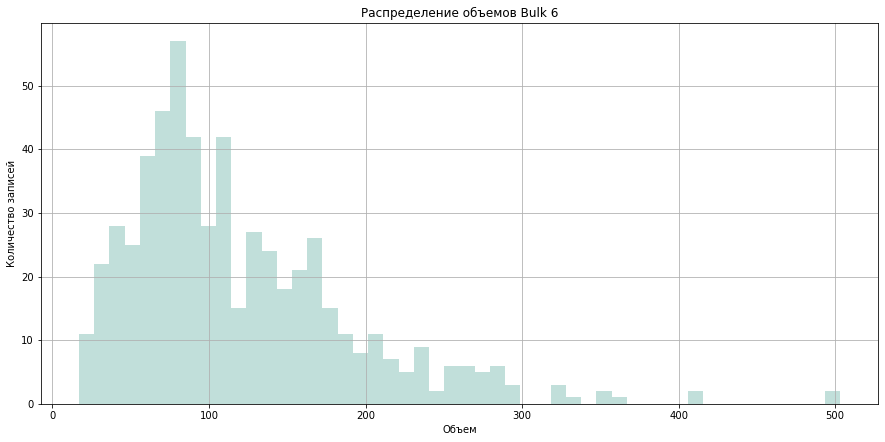

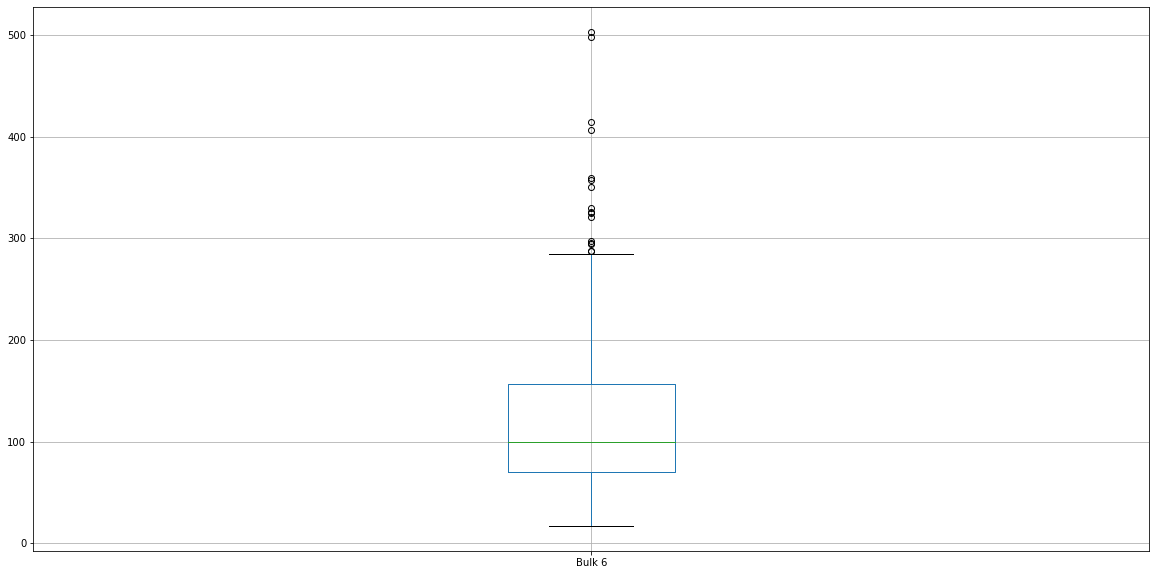

In [40]:
bulk_plotter('Bulk 6')

In [41]:
data_bulk['Bulk 6'].describe()

count    576.000000
mean     118.925347
std       72.057776
min       17.000000
25%       69.750000
50%      100.000000
75%      157.000000
max      503.000000
Name: Bulk 6, dtype: float64

Предположения подтвердились: в Bulk 6 медиана смещена влево, есть аномальные значения

**Bulk 12:**

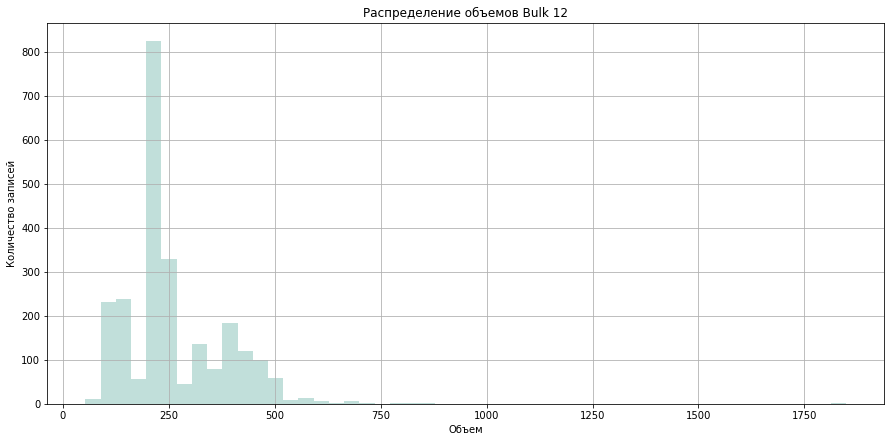

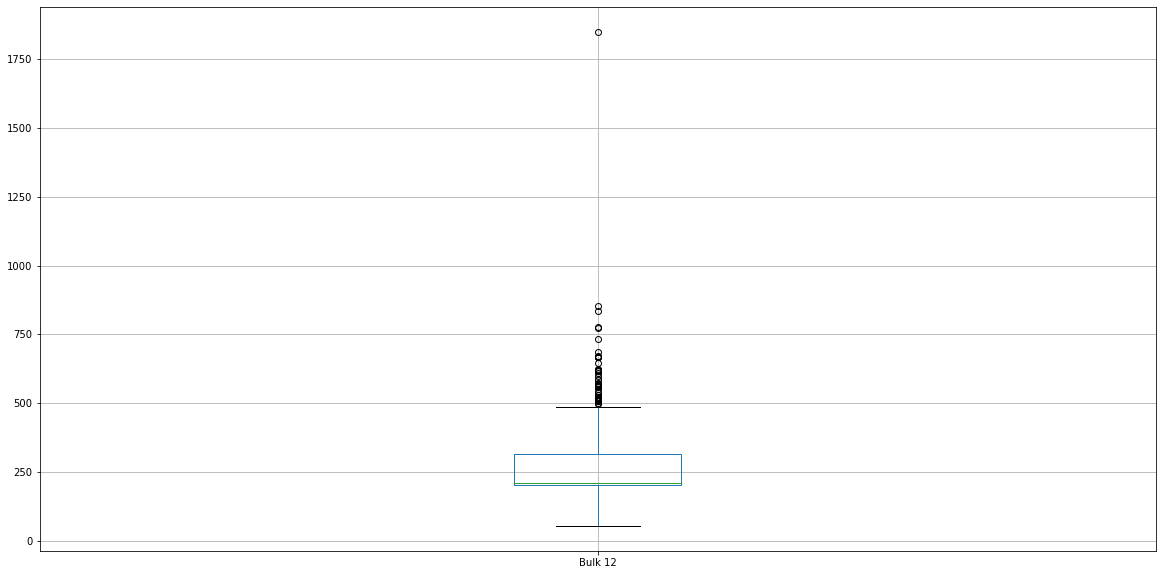

In [42]:
bulk_plotter('Bulk 12')

In [43]:
data_bulk['Bulk 12'].describe()

count    2450.000000
mean      260.471020
std       120.649269
min        53.000000
25%       204.000000
50%       208.000000
75%       316.000000
max      1849.000000
Name: Bulk 12, dtype: float64

Предположения подтвердились: в Bulk 12 много выбросов.

**Bulk 14:**

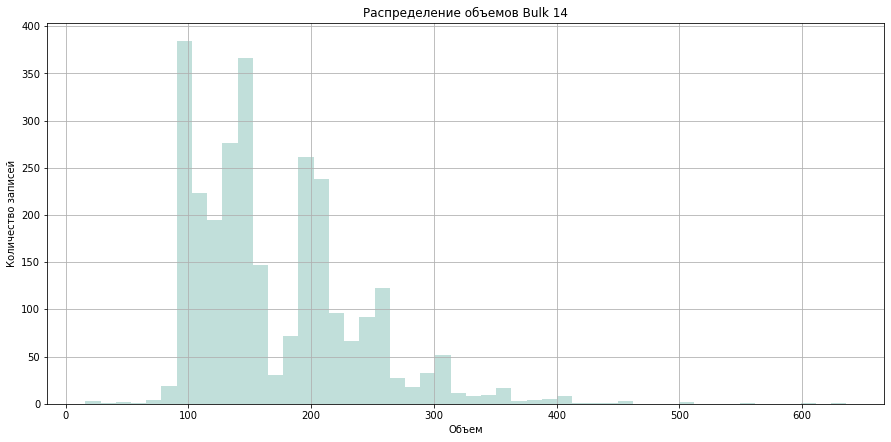

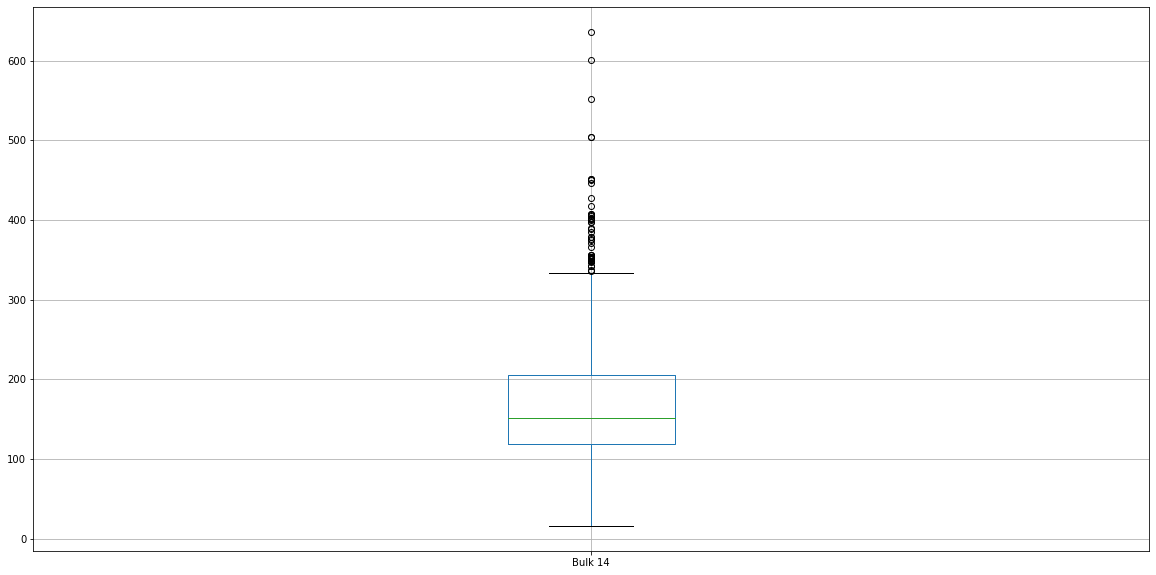

In [44]:
bulk_plotter('Bulk 14')

In [45]:
data_bulk['Bulk 14'].describe()

count    2806.000000
mean      170.284747
std        65.868652
min        16.000000
25%       119.000000
50%       151.000000
75%       205.750000
max       636.000000
Name: Bulk 14, dtype: float64

Предположения подтвердились: в Bulk 14 много выбросов.

**Bulk 15:**

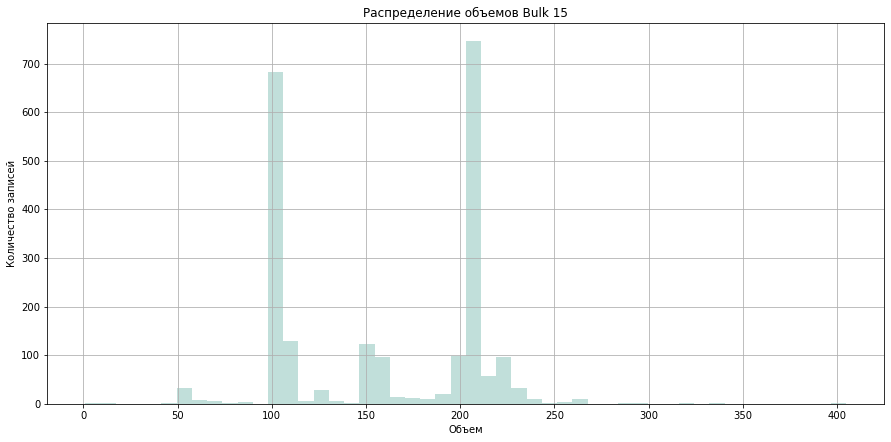

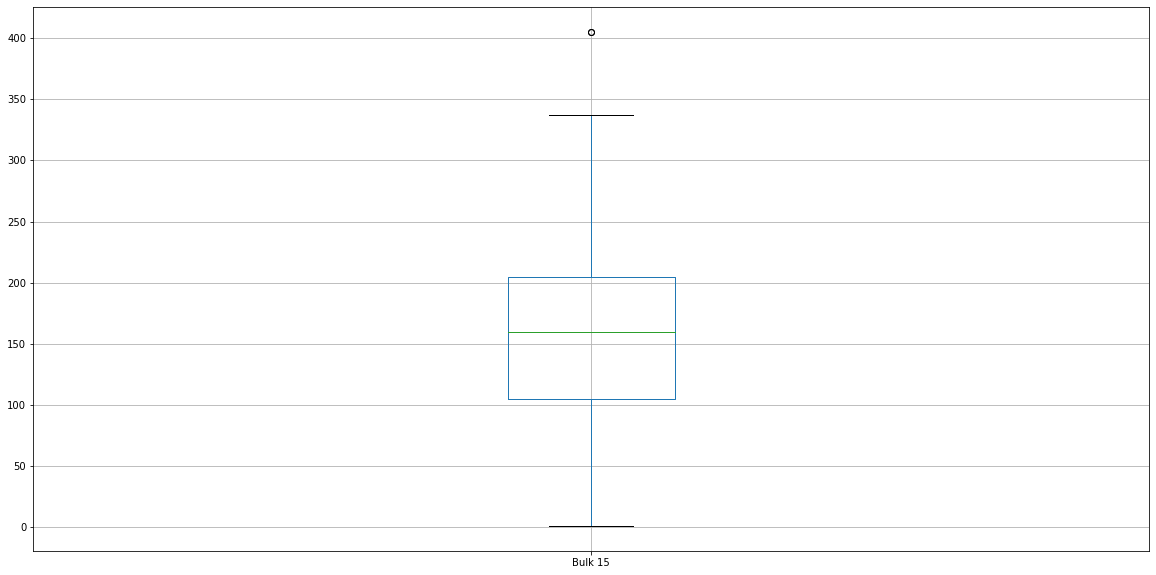

In [46]:
bulk_plotter('Bulk 15')

In [47]:
data_bulk['Bulk 15'].describe()

count    2248.000000
mean      160.513345
std        51.765319
min         1.000000
25%       105.000000
50%       160.000000
75%       205.000000
max       405.000000
Name: Bulk 15, dtype: float64

Распределение похоже на мультимодальное. Значит, этот сыпучий материал обычно подается в объемах, ограниченных ~3 разными диапазонами.

**Данные о времени подачи сыпучих материалов**

In [48]:
data_bulk_time = pd.read_csv('datasets/data_bulk_time_new.csv')

In [49]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [50]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [51]:
data_bulk_time.duplicated().sum()

0

В данных о времени подачи сыпучих материалов отсутствуют дубликаты, но в каждом признаке есть пропуски. Судя по идентичному количеству пропусков, записи о времени подачи существуют для объектов, у которых есть записи об объемах подачи.

**Предобработка данных о сыпучих материалах и создание признаков**

Найденные в исследовательском анализе выбросы удалять не будем, возможно, это особенности технологического процесса.

Пропуски в данных заменим на "0".

Данные о времени подачи в анализе не понадобятся.

Создадим копию данных для работы

In [52]:
bulk = data_bulk.copy()

Заполним пропуски нулями

In [53]:
bulk = bulk.fillna(0)

In [54]:
bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


Создадим признак для обучения - суммарный объем сыпучих материалов в партии. По нему можно будет судить о доле конкретного сыпучего материала на этапе обработки стали конкретной партии.

In [55]:
bulk['sum_bulk'] = bulk[bulk.columns[1:]].sum(axis=1)

In [56]:
bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


### 3. Данные о продувке сплава газом <a id='step1_3'></a>

Взглянем на данные:

In [57]:
data_gas = pd.read_csv('datasets/data_gas_new.csv')

In [58]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [59]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [60]:
data_gas.duplicated().sum()

0

In [61]:
data_gas['key'].nunique()

3239

В данных о продувке сплава газом отсутствуют пропуски и дубликаты. Каждый объект - запись для отдельной партии. Сплав продувают газом, признак - объем этого газа.

Распределение объема газа:

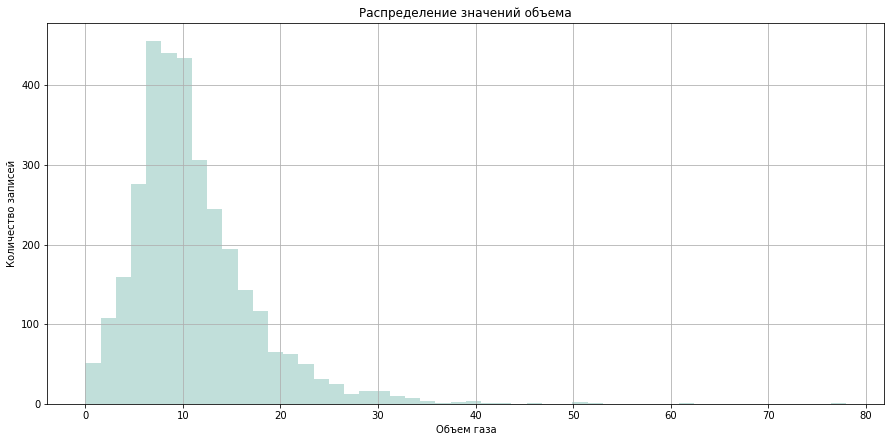

In [62]:
data_gas['Газ 1'].hist(bins=50, figsize=(15, 7), color='#A7D2CB', alpha=0.7)
plt.xlabel('Объем газа')
plt.ylabel('Количество записей')
plt.title('Распределение значений объема')
plt.show()

Есть выбросы. Убедимся:

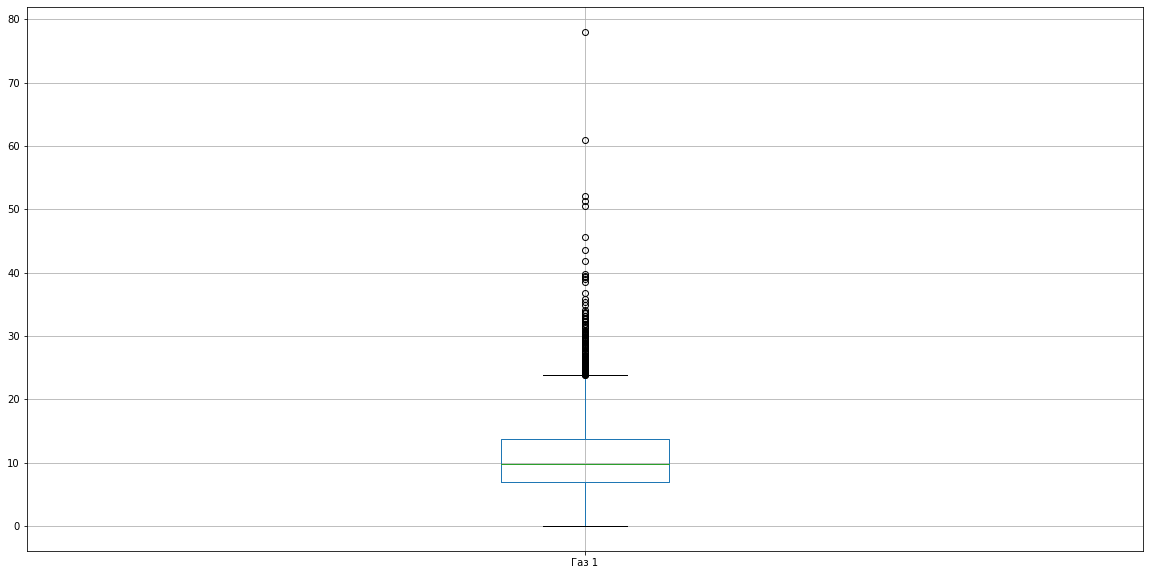

In [63]:
data_gas.boxplot(column='Газ 1', figsize=(20, 10))
plt.show()

In [64]:
data_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

Без выбросов вид распределение напоминает нормальное:

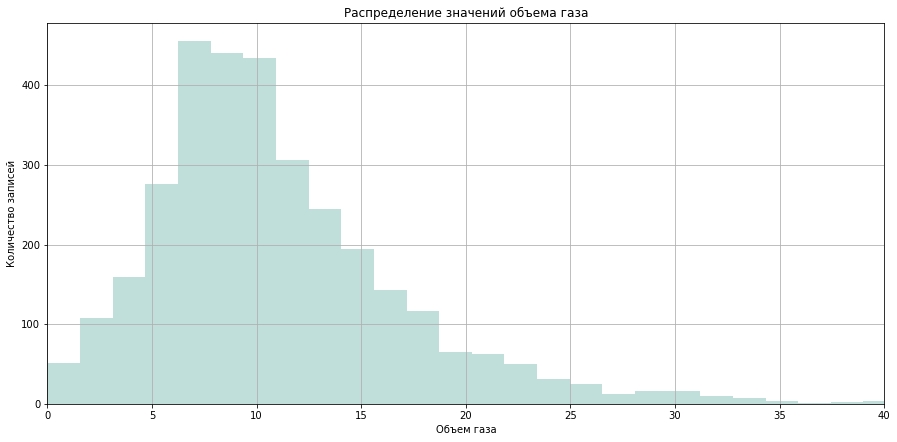

In [65]:
data_gas['Газ 1'].hist(bins=50, figsize=(15, 7), color='#A7D2CB', alpha=0.7)
plt.xlabel('Объем газа')
plt.ylabel('Количество записей')
plt.title('Распределение значений объема газа')
plt.xlim(0, 40) 
plt.show()

**Предобработка данных об объемах газа**

Найденные в исследовательском анализе выбросы удалять не будем, возможно, это особенности технологического процесса.

Пропусков в данных нет.

Переименуем столбцы для удобства

In [66]:
data_gas.columns = ['key', 'gas']

In [67]:
data_gas.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


### 4. Результаты измерения температуры <a id='step1_4'></a>

Взглянем на данные

In [68]:
data_temperature = pd.read_csv('datasets/data_temp_new.csv')

In [69]:
data_temperature.head(12)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [70]:
data_temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [71]:
data_temperature.duplicated().sum()

0

In [72]:
data_temperature['key'].nunique()

3216

В данных о результатах изменения температуры отсутствуют дубликаты, есть пропуски в записях температуры. Вероятно, температура не замерена для некоторых итераций. <br>
Для некоторых партий записи отсутствуют (3216 vs 3239 для газа).

Распределение температуры:

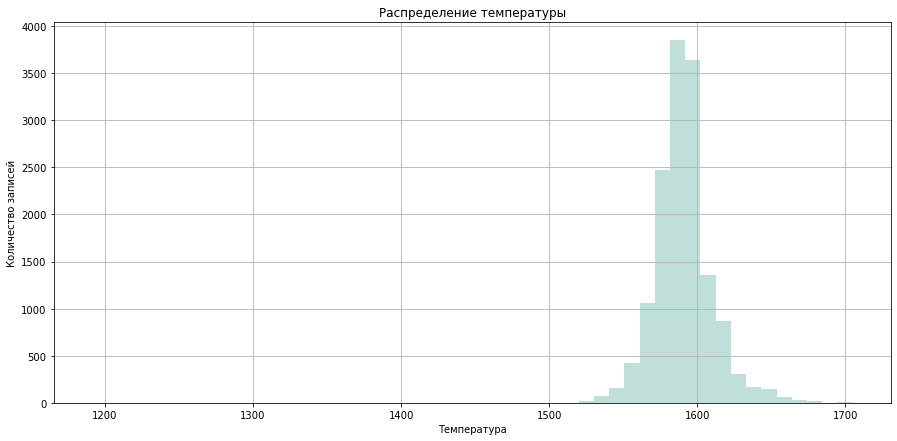

In [73]:
data_temperature['Температура'].hist(bins=50, figsize=(15, 7), color='#A7D2CB', alpha=0.7)
plt.xlabel('Температура')
plt.ylabel('Количество записей')
plt.title('Распределение температуры')
plt.show()

Есть выбросы, убедимся:

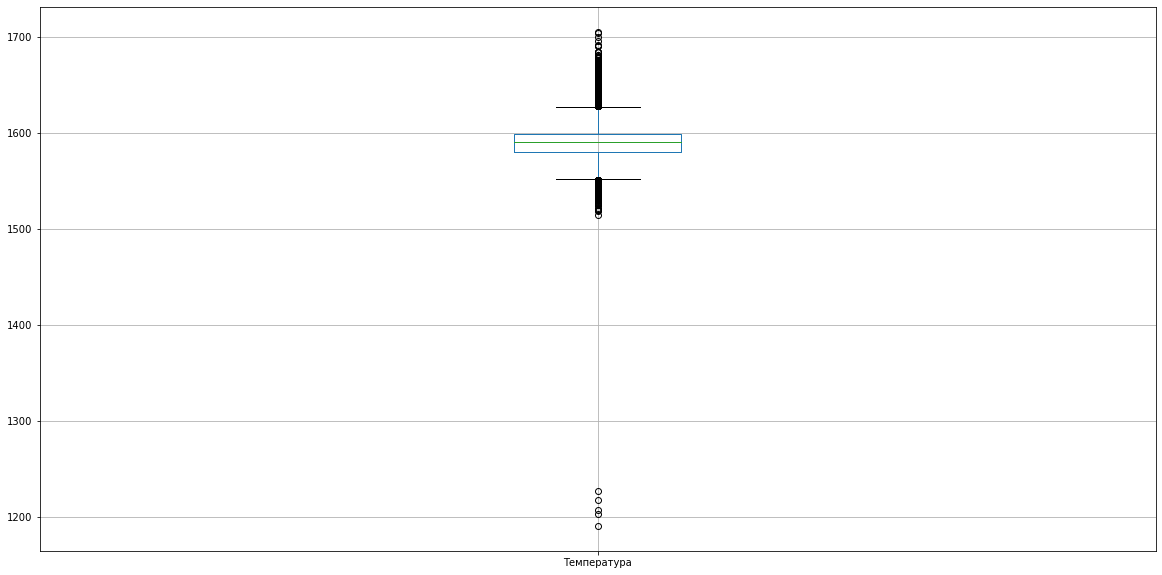

In [74]:
data_temperature.boxplot(column='Температура', figsize=(20, 10))
plt.show()

Без выбросов вид распределение напоминает нормальное:

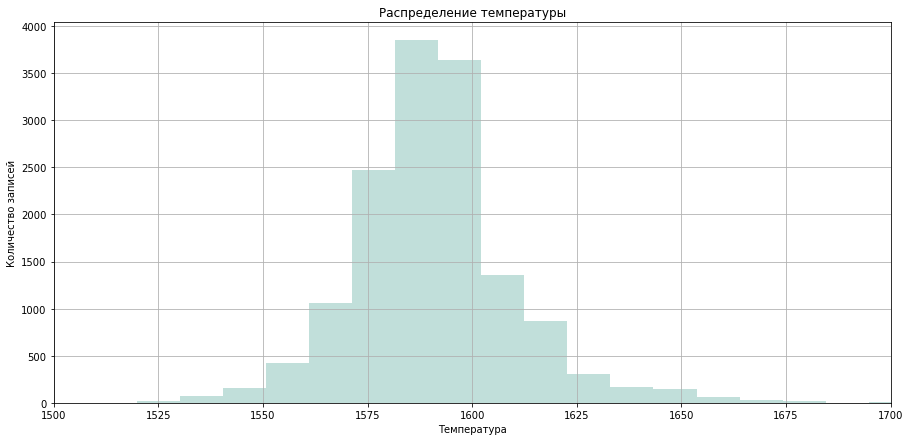

In [75]:
data_temperature['Температура'].hist(bins=50, figsize=(15, 7), color='#A7D2CB', alpha=0.7)
plt.xlabel('Температура')
plt.ylabel('Количество записей')
plt.title('Распределение температуры')
plt.xlim(1500, 1700) 
plt.show()

Возможно, аномально низкие значения существуют для одной партии и это особенность этой партии:

In [76]:
data_temperature[data_temperature['Температура'] < 1300]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


Аномально низкие значения существуют для разных партий, вероятно, ошибка измерений или нарушение технологического процесса.

**Предобработка данных о температуре и создание признаков**

Создадим копию данных для работы

In [77]:
data_temp = data_temperature.copy()

Целевой признак - температура розлива, т.е. выходная температура каждой партии. 

Ранее выяснено, что в данных есть выбросы. 

Температура плавления некоторых марок сталей может опускаться до 1300 °С. Будем считать выбросами температуру менее 1300 °С.

Сначала сформируем таблицу, состоящую из столбца с номером партии и столбца с выходной температурой. Проконтролируем, чтобы данных, где есть пропуски в записи температуры, не было. Создадим признак входной температуры и разницы во времени замеров. Затем удалим данные с выбросами.


Для начала посмотрим, для всех ли партий записана выходная температура. Если есть партии лишь с одной записью, то непонятно, выходная ли это температура, и такие данные следует удалить.

In [78]:
(
    data_temp
    .pivot_table(index='key', values='Температура', aggfunc='count')
    .value_counts()
)

Температура
1              741
5              688
6              580
4              395
7              388
8              152
3              136
9               66
2               32
10              21
11               7
12               3
13               2
14               2
16               2
17               1
dtype: int64

In [79]:
(741 / data_temp['key'].nunique()) * 100

23.041044776119403

In [80]:
(741 / data_temp.shape[0]) * 100

4.095732920627902

Для 741 партии существует лишь один замер температуры. Это 23% от общего количества партий и 4% от общего количества данных. Делать нечего, соответствующие записи придется удалять.

Создадим таблицу с количеством замеров температуры

In [81]:
temp = data_temp.pivot_table(index='key', values='Температура', aggfunc='count')
temp.columns = ['count']
temp.head()

,count
key,
1,6
2,5
3,6
4,5
5,5


Добавим столбец с выходной температурой для партии

In [82]:
temp['temperature'] = data_temp.pivot_table(index='key', values='Температура', aggfunc='last')
temp.head()

,count,temperature
key,,
1,6,1613.0
2,5,1602.0
3,6,1599.0
4,5,1625.0
5,5,1602.0


Добавим признак - входное значение измерения температуры

In [83]:
temp['first_temperature'] = data_temp.pivot_table(index='key', values='Температура', aggfunc='first')
temp.head()

,count,temperature,first_temperature
key,,,
1,6,1613.0,1571.0
2,5,1602.0,1581.0
3,6,1599.0,1596.0
4,5,1625.0,1601.0
5,5,1602.0,1576.0


In [84]:
temp.shape

(3216, 3)

Удаляем данные с одним замером температуры

In [85]:
temp = temp[temp['count'] != 1]

In [86]:
temp.shape

(2475, 3)

Потеряли те самые 23% данных.

Удалим лишний признак - количество замеров температуры, вряд ли он сильно повлияет на будущую модель.

In [87]:
temp = temp.drop(['count'], axis=1)

In [88]:
temp.head()

,temperature,first_temperature
key,,
1,1613.0,1571.0
2,1602.0,1581.0
3,1599.0,1596.0
4,1625.0,1601.0
5,1602.0,1576.0


Создадим новый признак - разницу во времени замера входной и выходной температур.

In [89]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [90]:
temp['time_delta'] = data_temp.pivot_table(index='key', values='Время замера', aggfunc='last') - data_temp.pivot_table(index='key', values='Время замера', aggfunc='first')

In [91]:
temp['time_delta'] = temp['time_delta'].dt.total_seconds()

In [92]:
temp.head()

,temperature,first_temperature,time_delta
key,,,
1,1613.0,1571.0,1714.0
2,1602.0,1581.0,1265.0
3,1599.0,1596.0,1753.0
4,1625.0,1601.0,1220.0
5,1602.0,1576.0,1536.0


Взглянем на информацию о данных перед удалением выбросов

In [93]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature        2475 non-null   float64
 1   first_temperature  2475 non-null   float64
 2   time_delta         2475 non-null   float64
dtypes: float64(3)
memory usage: 77.3 KB


Удаляем выбросы

In [94]:
temp = temp[temp['temperature'] > 1300]

In [95]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature        2475 non-null   float64
 1   first_temperature  2475 non-null   float64
 2   time_delta         2475 non-null   float64
dtypes: float64(3)
memory usage: 77.3 KB


От пропусков избавились в процессе создания признаков.

### 5. Данные о проволочных материалах <a id='step1_5'></a>

Взглянем на данные

In [96]:
data_wire = pd.read_csv('datasets/data_wire_new.csv')

In [97]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [99]:
data_wire.duplicated().sum()

0

In [100]:
data_wire['key'].nunique()

3081

В данных об объемах проволочного материала отсутствуют дубликаты, есть много пропусков для большинства признаков. Точно можно работать с Wire 1, Wire 2. Похожая с Bulk ситуация. 
Для некоторых партий записи отсутствуют (3081 vs 3239 для газа).

Распределение данных:

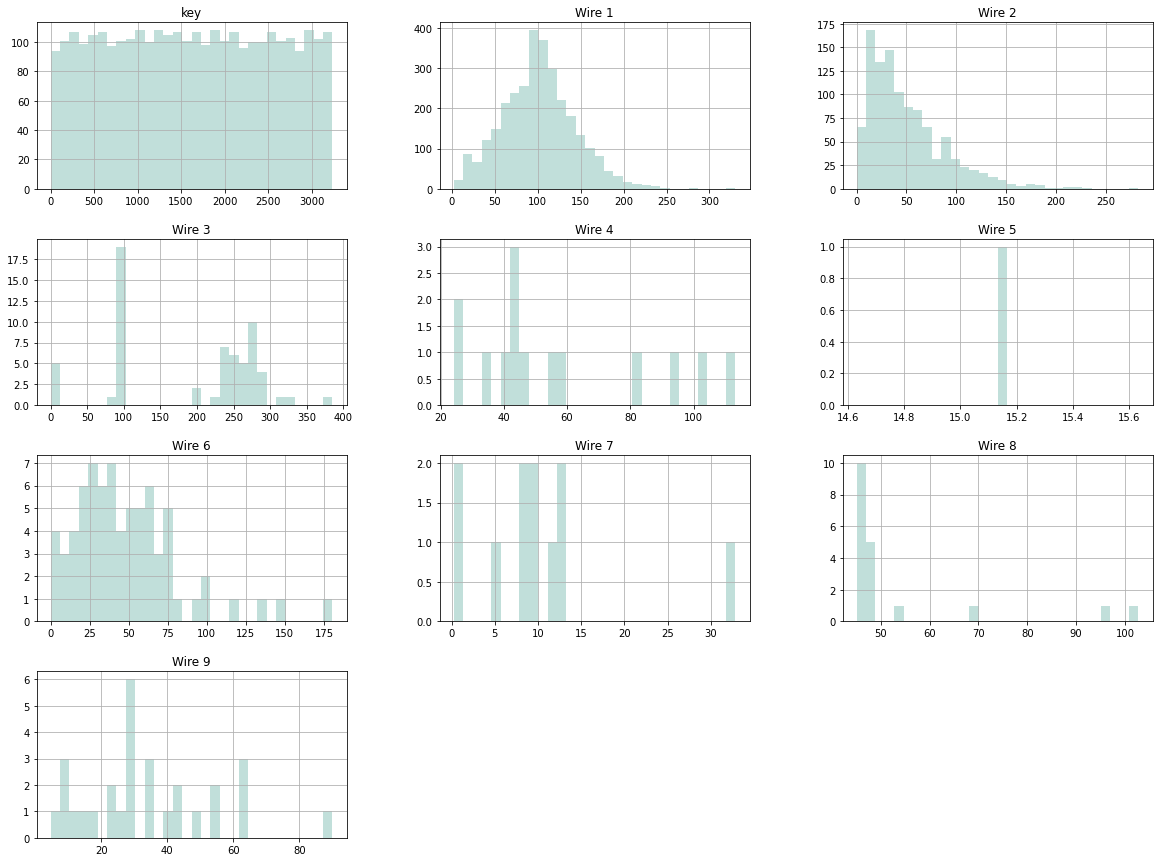

In [101]:
data_wire.hist(bins=30, figsize=(20, 15), color='#A7D2CB', alpha=0.7)
plt.show()

1. Wire 1 - Похоже, что есть выбросы. Распределение похоже на нормальное.
2. Wire 2 - Есть выбросы. Медиана смещена влево.

In [102]:
# Функция для построения графиков для проволочных материалов:
def wire_plotter(name):
    data_wire[name].hist(bins=50, figsize=(15, 7), color='#A7D2CB', alpha=0.7)
    plt.xlabel('Объем')
    plt.ylabel('Количество записей')
    plt.title(f'Распределение объемов {name}')
    plt.show()
    
    data_wire.boxplot(column=name, figsize=(20, 10))
    plt.show()

**Wire 1:**

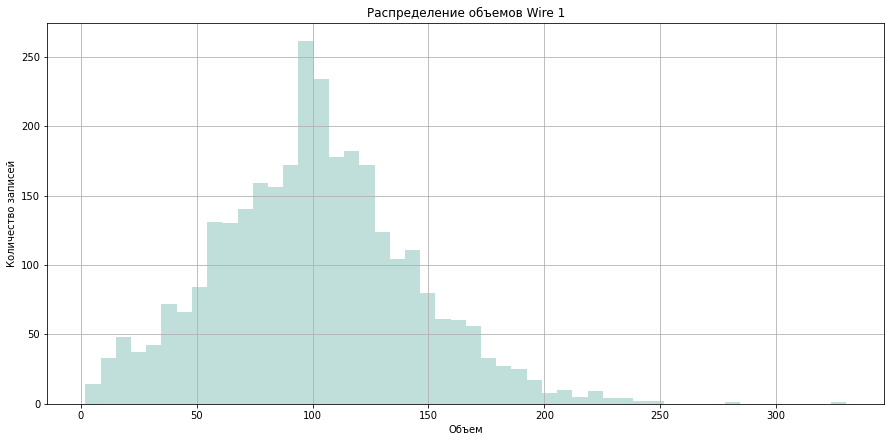

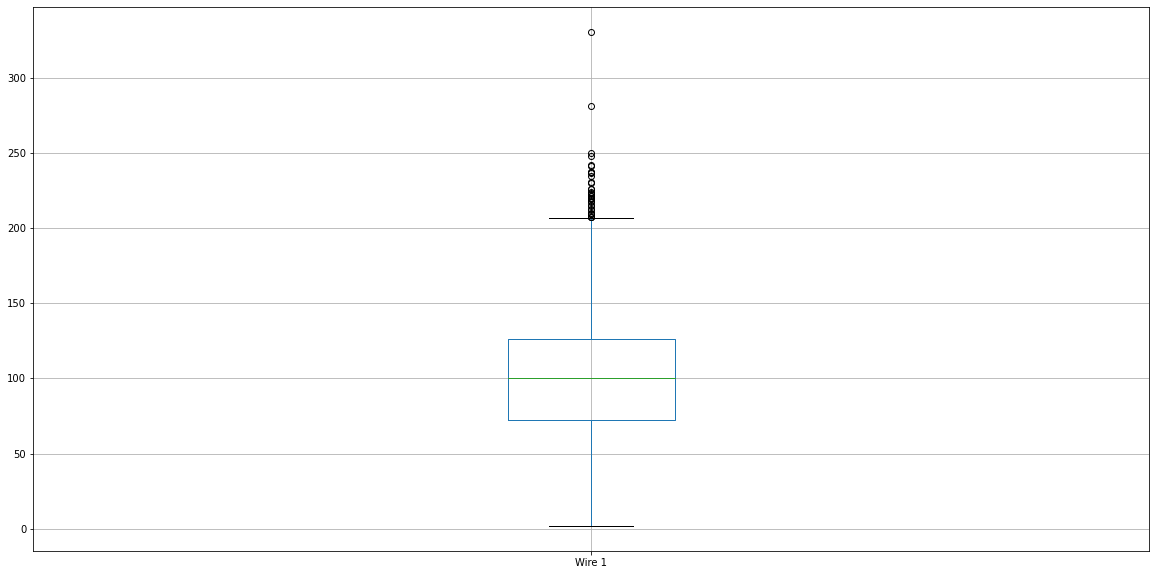

In [103]:
wire_plotter('Wire 1')

In [104]:
data_wire['Wire 1'].describe()

count    3055.000000
mean      100.895853
std        42.012518
min         1.918800
25%        72.115684
50%       100.158234
75%       126.060483
max       330.314424
Name: Wire 1, dtype: float64

Есть небольшие выбросы, распределение похоже на нормальное.

**Wire 2:**

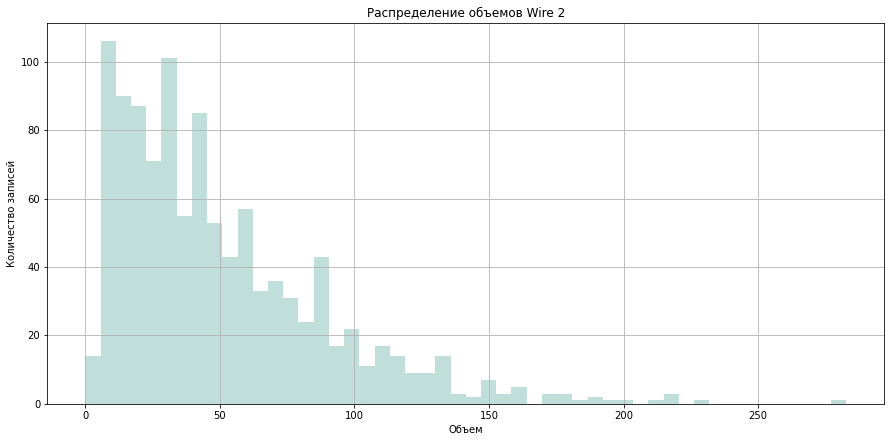

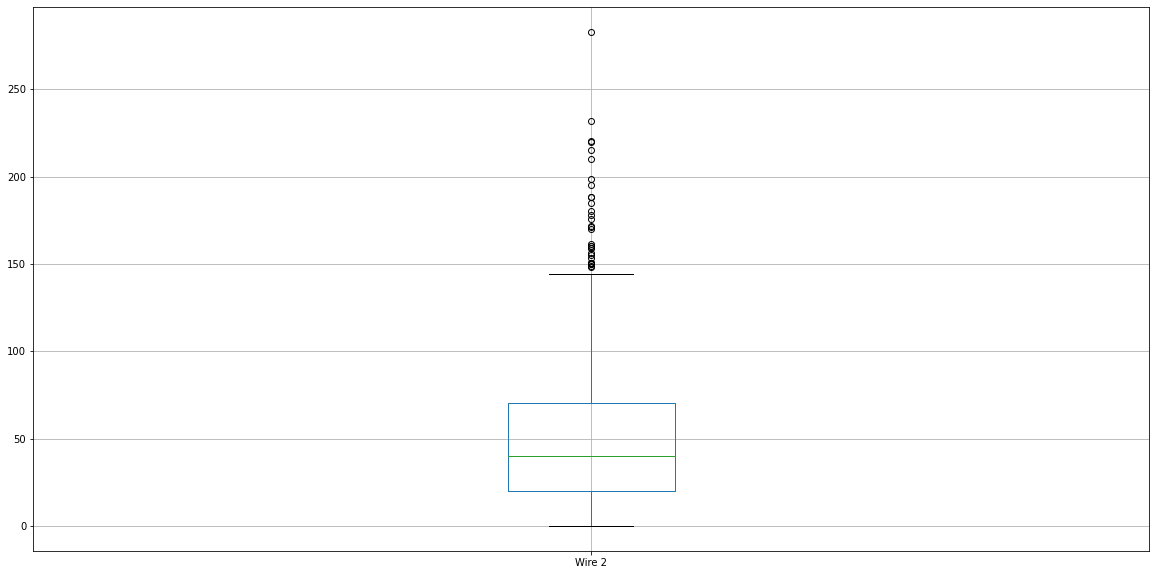

In [105]:
wire_plotter('Wire 2')

In [106]:
data_wire['Wire 2'].describe()

count    1079.000000
mean       50.577323
std        39.320216
min         0.030160
25%        20.193680
50%        40.142956
75%        70.227558
max       282.780152
Name: Wire 2, dtype: float64

Много выбросов, медиана смещена влево.

**Данные о времени подачи сыпучих материалов**

In [107]:
data_wire_time = pd.read_csv('datasets/data_wire_time_new.csv')

In [108]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [110]:
data_wire_time.duplicated().sum()

0

В данных о времени для проволочного материала нет дубликатов, записи для времени соответствуют записям, где есть отметки об объемах проволочного материала.

**Предобработка данных о проволочных материалах и создание признаков**

Ситуация здесь похожа на ситуацию с сыпучими материалами.

Найденные в исследовательском анализе выбросы удалять не будем, возможно, это особенности технологического процесса.

Пропуски в данных заменим на "0".

Данные о времени подачи в анализе не понадобятся.

Создадим копию данных для дальнейшей работы

In [111]:
wire = data_wire.copy()

Заполним пропуски нулями

In [112]:
wire = wire.fillna(0)

In [113]:
wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Новый признак - количество проволочного материала в каждой партии

In [114]:
wire['sum_wire'] = wire[wire.columns[1:]].sum(axis=1)

In [115]:
wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


## Объединение признаков в один датафрейм<a id='step2'></a>

In [116]:
data = (
    temp
    .merge(arc_work, how ='left', on='key')
    .merge(data_gas, how ='left', on='key')
    .merge(bulk, how ='left', on='key')
    .merge(wire, how ='left', on='key')
)

In [117]:
data = data.set_index('key')

In [118]:
data.head()

,temperature,first_temperature,time_delta,work,arc_count,gas,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
key,,,,,,,,,,,,,,,,,,,,,
1,1613.0,1571.0,1714.0,770.282114,5,29.749986,0.0,0.0,0.0,43.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
2,1602.0,1581.0,1265.0,481.760005,4,12.555561,0.0,0.0,0.0,73.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
3,1599.0,1596.0,1753.0,722.837668,5,28.554793,0.0,0.0,0.0,34.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
4,1625.0,1601.0,1220.0,683.455597,4,18.841219,0.0,0.0,0.0,81.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
5,1602.0,1576.0,1536.0,512.169934,4,5.413692,0.0,0.0,0.0,78.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature        2475 non-null   float64
 1   first_temperature  2475 non-null   float64
 2   time_delta         2475 non-null   float64
 3   work               2475 non-null   float64
 4   arc_count          2475 non-null   int64  
 5   gas                2473 non-null   float64
 6   Bulk 1             2407 non-null   float64
 7   Bulk 2             2407 non-null   float64
 8   Bulk 3             2407 non-null   float64
 9   Bulk 4             2407 non-null   float64
 10  Bulk 5             2407 non-null   float64
 11  Bulk 6             2407 non-null   float64
 12  Bulk 7             2407 non-null   float64
 13  Bulk 8             2407 non-null   float64
 14  Bulk 9             2407 non-null   float64
 15  Bulk 10            2407 non-null   float64
 16  Bulk 11            2407 

Для многих партий отсутствуют записи некоторых факторов. Проверим, сколько данных мы потеряем, удалив данные с пропусками.

In [120]:
(1 - (data.dropna().shape[0] / data.shape[0])) * 100

5.898989898989903

Потеряем примерно 6% данных. Даже с учетом удаления выбросов (единичные случаи), данных теряем немного, можно удалять.

In [121]:
data = data.dropna()

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature        2329 non-null   float64
 1   first_temperature  2329 non-null   float64
 2   time_delta         2329 non-null   float64
 3   work               2329 non-null   float64
 4   arc_count          2329 non-null   int64  
 5   gas                2329 non-null   float64
 6   Bulk 1             2329 non-null   float64
 7   Bulk 2             2329 non-null   float64
 8   Bulk 3             2329 non-null   float64
 9   Bulk 4             2329 non-null   float64
 10  Bulk 5             2329 non-null   float64
 11  Bulk 6             2329 non-null   float64
 12  Bulk 7             2329 non-null   float64
 13  Bulk 8             2329 non-null   float64
 14  Bulk 9             2329 non-null   float64
 15  Bulk 10            2329 non-null   float64
 16  Bulk 11            2329 

Изучим данные на предмет существования мультиколлинеарности

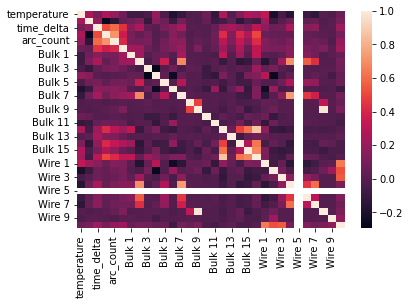

In [123]:
sns.heatmap(data.corr())
plt.rcParams['figure.figsize'] = [20, 15]
plt.show()

Бросается в глаза белая линия Wire 5

In [124]:
data['Wire 5'].unique()

array([0.])

В Wire 5 остались лишь нули, удалим этот признак

Наблюдается корреляция между Bulk 9 и Wire 8, Bulk 2 и Bulk 7, Bulk 7 и Wire 4, Bulk 12 и Bulk 15, Bulk 12 и sum_bulk.

In [125]:
data['Bulk 9'].corr(data['Wire 8'])

0.9749686403984961

Очень высокая корреляция.

In [126]:
data['Bulk 12'].corr(data['sum_bulk'])

0.8678912701290873

Высокая корреляция.

In [127]:
data['Bulk 2'].corr(data['Bulk 7'])

0.6793557926765945

Средняя корреляция.

In [128]:
data['Bulk 7'].corr(data['Wire 4'])

0.7405719889021148

Средняя корреляция.

In [129]:
data['Bulk 12'].corr(data['Bulk 15'])

0.6144793601036254

Средняя корреляция.

С уверенностью удаляем столбец 'Bulk 9', так как он взаимосвязан с 'Wire 8'. Также удаляем 'Wire 5' и 'Bulk 12'.

In [130]:
data = data.drop(['Bulk 9', 'Wire 5', 'Bulk 12'], axis=1)

Итоговый датасет для обучения:

In [131]:
data.head()

,temperature,first_temperature,time_delta,work,arc_count,gas,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,sum_bulk,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
key,,,,,,,,,,,,,,,,,,,,,
1,1613.0,1571.0,1714.0,770.282114,5,29.749986,0.0,0.0,0.0,43.0,...,553.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
2,1602.0,1581.0,1265.0,481.760005,4,12.555561,0.0,0.0,0.0,73.0,...,582.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
3,1599.0,1596.0,1753.0,722.837668,5,28.554793,0.0,0.0,0.0,34.0,...,544.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
4,1625.0,1601.0,1220.0,683.455597,4,18.841219,0.0,0.0,0.0,81.0,...,595.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
5,1602.0,1576.0,1536.0,512.169934,4,5.413692,0.0,0.0,0.0,78.0,...,584.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


Посмотрим, остались ли аномалии в данных

In [132]:
model = KNN()
estimation_knn = model.fit_predict(data)
outliers_knn = (estimation_knn == 1).sum()
print("Количество аномалий (KNN): ", outliers_knn)

Количество аномалий (KNN):  233


KNN определил аномалии, пока трогать их не будем.

## Обучение моделей<a id='step3'></a>

Делим данные на выборки: 75% на обучающую, 25% на тестовую

In [133]:
data_train, data_test = train_test_split(data, test_size=0.25, random_state=170723)

Выделим признаки для обучения и таргет

In [134]:
features_train = data_train.drop(['temperature'], axis=1)
target_train = data_train['temperature']

features_test = data_test.drop(['temperature'], axis=1)
target_test = data_test['temperature']

Проверим правильно ли поделили данные

In [135]:
data_test.shape[0] / data.shape[0]

0.25032202662086733

### 1. Линейная регрессия<a id='step3_1'></a>

Подберем модель с наилучшей метрикой качества. Начнем с линейной регрессии.

Изучим качество модели с помощью кросс-валидации

In [136]:
%%time

model = LinearRegression()
model.fit(features_train, target_train) 
result = cross_val_score(model, features_train, target_train, cv=5, scoring='neg_mean_absolute_error').mean()
print('MAE:', abs(result))

MAE: 6.815551825707464
CPU times: total: 141 ms
Wall time: 66.8 ms


Получили MAE чуть больше 6.8 при ТЗ MAE ≤ 6.8, неплохой результат!

### 2. Случайный лес<a id='step3_2'></a>

Подберем параметры случайного леса с помощью GridSearch. Варьируем количество деревьев от 3 до 25, глубину от 3 до 15.

In [137]:
%%time

params = { 'n_estimators' : range(3, 26), 
           'max_depth': range(3, 16) }

model = RandomForestRegressor(random_state=170723)

forest_grid = GridSearchCV(model, params, scoring='neg_mean_absolute_error')
forest_grid.fit(features_train, target_train)

print('Наилучшие гиперпараметры: '+ str(forest_grid.best_params_))
print('Наименьшая MAE: '+ str(abs(forest_grid.best_score_)))

Наилучшие гиперпараметры: {'max_depth': 9, 'n_estimators': 25}
Наименьшая MAE: 6.691769949700188
CPU times: total: 3min 53s
Wall time: 3min 53s


MAE около 6.7, хороший результат.

### 3. CatBoost<a id='step3_3'></a>

Подберем параметры КБ с помощью GridSearch. Варьируем скорость обучения от 0.2 до 0.9 с шагом 0.1, глубину от 3 до 15.

In [138]:
%%time

params = { 'depth' : range(3, 16),
           'learning_rate': np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])}

model = CatBoostRegressor(random_state=170723, verbose=False, iterations=50, eval_metric='MAE')
grid_search_result = model.grid_search(params,
                                             X=features_train,
                                             y=target_train,
                                             cv=5,
                                             partition_random_seed=170723,
                                             calc_cv_statistics=True,
                                             search_by_train_test_split=True,
                                             refit=True,
                                             shuffle=False,
                                             train_size=0.8,
                                             verbose=False )



print('Наилучшие гиперпараметры:', grid_search_result['params'])



bestTest = 10.28168346
bestIteration = 49


bestTest = 10.03719766
bestIteration = 49


bestTest = 9.609271777
bestIteration = 49


bestTest = 9.772526418
bestIteration = 48


bestTest = 10.25070807
bestIteration = 41


bestTest = 10.0507253
bestIteration = 47


bestTest = 10.29193143
bestIteration = 28


bestTest = 10.25629468
bestIteration = 35


bestTest = 12.9954763
bestIteration = 48


bestTest = 13.14278559
bestIteration = 49


bestTest = 12.67811275
bestIteration = 48


bestTest = 12.47285844
bestIteration = 48


bestTest = 13.45649243
bestIteration = 48


bestTest = 12.80117759
bestIteration = 49


bestTest = 15.47229045
bestIteration = 45


bestTest = 12.60818779
bestIteration = 20


bestTest = 15.23000563
bestIteration = 49


bestTest = 14.93042096
bestIteration = 49


bestTest = 15.48554388
bestIteration = 48


bestTest = 17.79901385
bestIteration = 47


bestTest = 15.45197616
bestIteration = 43


bestTest = 17.70810217
bestIteration = 26


bestTest = 18.31190322
bestIterat

In [139]:
print('MAE:', model.get_best_score()['learn']['MAE'])

MAE: 5.64502044456952


MAE около 5.65 - отличный результат!

Гиперпараметры подобранной модели:

In [140]:
model.get_params()

{'iterations': 50,
 'loss_function': 'RMSE',
 'verbose': False,
 'eval_metric': 'MAE',
 'random_state': 170723,
 'depth': 3,
 'learning_rate': 0.4}

## Тестирование модели<a id='step4'></a>

Наилучший результат показал CatBoost, протестируем его

In [142]:
best_model = CatBoostRegressor(random_state=170723, verbose=False, iterations=50, eval_metric='MAE', depth=3, learning_rate=0.4)
best_model.fit(features_train, target_train) 
predictions = best_model.predict(features_test)
result = mean_absolute_error(target_test, predictions)
print('MAE:', result)

MAE: 6.407283078693335


Исследуем модель на адекватность. Сравним с моделью, которая всегда предсказывает медианное значение выходной температуры.

In [143]:
dummy = DummyRegressor(strategy='median')
dummy.fit(features_train, target_train)
predictions = dummy.predict(features_test)
result = mean_absolute_error(target_test, predictions)
print('MAE:', result)

MAE: 7.900514579759863


Полученная модель КБ адекватна, метрика качества лучше метрики наивной модели.

## Исследование важности факторов<a id='step5'></a>

Используем библиотеку SHAP для исследования важности факторов

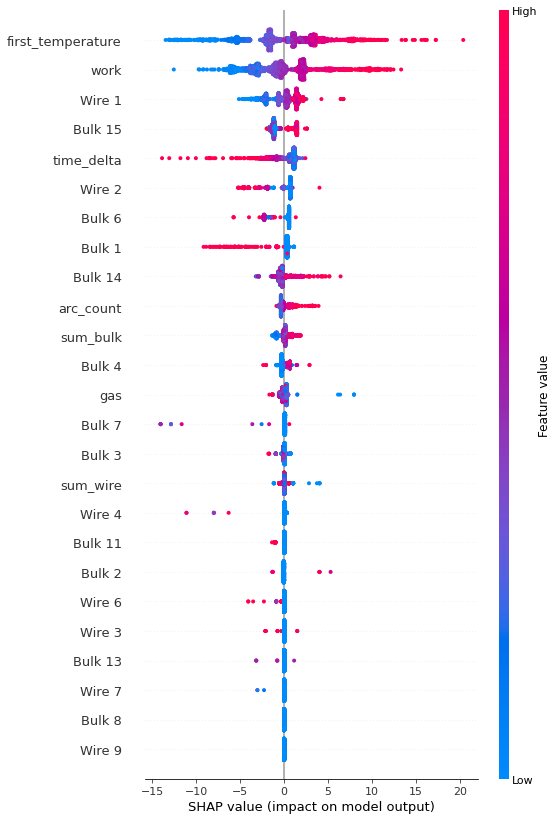

In [144]:
shap_test = shap.TreeExplainer(best_model).shap_values(features_train)
shap.summary_plot(shap_test, features_train,
                      max_display=25, auto_size_plot=True)

Из графика можно сделать некоторые выводы:
1. Wire 7, Bulk 8, Wire 9 почти не влияют на температуру. Скорее всего для этих признаков недостаточно данных. Не стоит удалять эти факторы, так как они, возможно, важны для бизнеса (технологического процесса);
2. Наибольшее влияние оказывают признаки first_temperature, work, Wire 1, причем зависимость между признаками и таргетом прямая. Новые признаки были созданы не зря;
3. Некоторые данные обратно пропорциональны температуре розлива: чем больше объемы примесей Wire 2, Bulk 6, Bulk 1, тем меньше выходная температура. Возможно, во избежание перегрева стоит использовать именно их.
4. Увеличение объемов Wire 1, Bulk 15, Bulk 14 и количества включений электродов способствуют перегреву.

# Заключение<a id='step6'></a>

Таким образом, в итоге работы над проектом была получена модель, предсказывающая температуру стали, что поможет снизить затраты бизнеса на электроэнергию. Итоговая MAE равна 6.4, ТЗ (MAE ≤ 6.8) выполнено.

В ходе работы были выполнены следующие ключевые шаги:

1. Проведен исследовательский анализ данных, выявлены особенности данных и аномалии;
2. Выполнена предобработка данных: часть данных удалена, пропуски в сыпучих и проволочных материалах заменены нулем;
3. Созданы новые признаки для обучения, позволившие избавиться от мультиколлинерности некоторых признаков и, соответственно, повысить качество модели;
4. Сформирован итоговый датасет, лишние признаки удалены после финальной проверки на мультиколлинеарность;
5. Датасет был разбит на тренировочную (75%) и тестовую(25%) выборки;
6. Были обучены модели: Линейная регрессия, Случайный лес, CatBoost. Наилучший результат показал CatBoost: MAE около 5.65;
   *Гиперпараметры модели: random_state=170723, iterations=50, depth=3, learning_rate=0.4;*
7. Наилучшая модель была протестирована: MAE = 6.4. ТЗ выполнено;
8. Модель исследована на адекватность;
9. Был выполнен анализ важности факторов, сделаны выводы о том, что может влиять на перегрев на этапе обработки стали.

Для обучения были сформированы следующие признаки:

1. Температура розлива - целевой признак.<br>
   Пропущенные значения удалены; данные с одним замером температуры удалены.
2. Первое измеренное значение температуры.
3. Разница во времени первого и последнего замеров температуры в секундах.
4. Работа: просуммировано в рамках каждой партии произведение полной мощности на время работы электродов.
5. Количество включений электродов во время обработки отдельной партии.
6. Объем продуваемого газа.
7. Объем каждого сыпучего материала (кроме №9, №12). Пропуски заменены на ноль.
8. Суммарный объем добавленных сыпучих материалов для партии.
9. Объем каждого проволочного материала (кроме №5). Пропуски заменены на ноль.
10. Суммарный объем добавленных проволочных материалов для партии.

Из итоговой таблицы с признаками удалены записи, где есть хоть один пропуск. Всего потеряно около 6% данных.

Для улучшения решения, возможно, стоит пересмотреть саму задачу, перестроить ее в задачу классификации, так как нам важно не точное значение температуры при перегреве, а сам факт перегрева:

- Уточняем у заказчика рабочий диапазон температур этапа обработки;
- Ставим метку, когда наблюдаемая температура выше этого диапазона (перегрев).
- В итоге изучаем какие факторы способствовали этому перегреву.

[В начало](#start)